Read data from csv and create a basic Time serie object

In [409]:
library(forecast)
library(car)
library(ggplot2)
#library(zoo)
library(scales)
library(repr)

options(scipen=999)

# Change plot size to 10 x 6
options(repr.plot.width=8, repr.plot.height=5)

jp_data <- read.csv2("japan_employment.csv")
#Remove last row, 2015-01
jp_data <- jp_data[1:nrow(jp_data) - 1,]
jp_data$Date <- as.Date(jp_data$Date, format = "%Y-%m-%d")
#Create column with month value
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
#jp_observed_ts <- zoo(jp_data)

Display the unmodified time serie

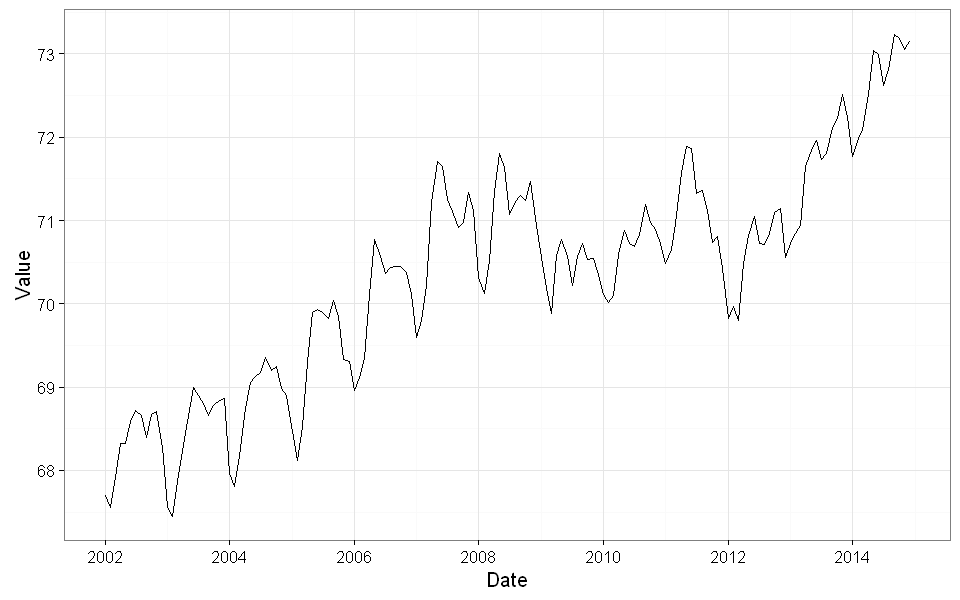

In [410]:
ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = Value)) +
    theme_bw()

Decompose time serie

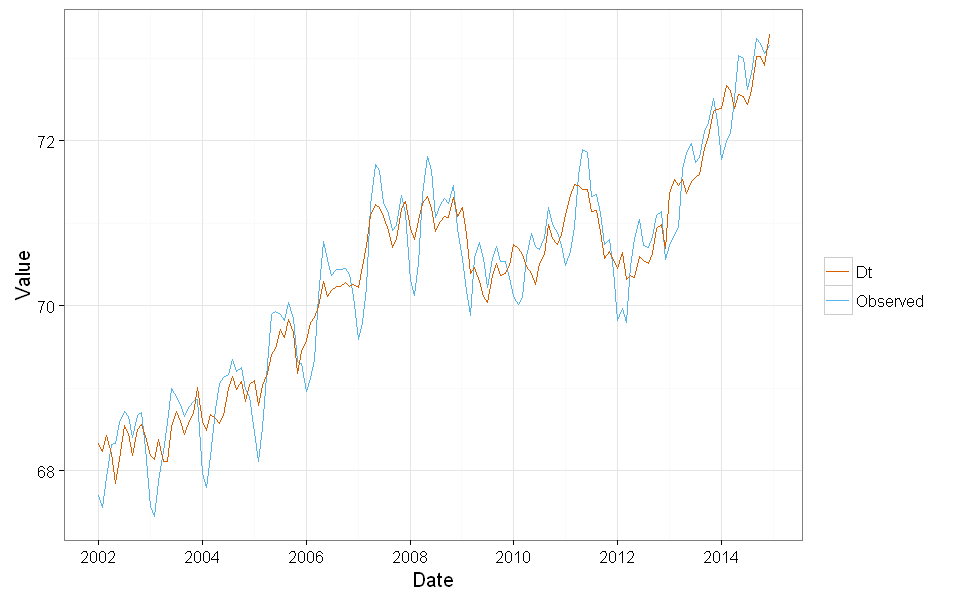

In [411]:
#Calculate moving average
jp_data$Seasonal_Comp <- ma(jp_data$Value, 12)
jp_data$Seasonal_Comp <- ma(jp_data$Seasonal, 4, centre = TRUE)

#Calculate rough seasonal component
jp_data$Seasonal_Comp <- jp_data$Value - jp_data$Seasonal_Comp

temp_monthly_comp <- aggregate(jp_data$Seasonal_Comp ~ jp_data$Month, FUN = mean)
colnames(temp_monthly_comp) <- c("Month", "Seasonal_Comp")

#Calculate how much bigger or smaller the rough component is
fix_ratio <- sum(temp_monthly_comp$Seasonal_Comp) / 12

#Fix the rough seasonal component
temp_monthly_comp$Seasonal_Comp <- temp_monthly_comp$Seasonal_Comp - fix_ratio
jp_data$Seasonal_Comp <- rep(temp_monthly_comp$Seasonal_Comp, 13)

jp_data$Dt <- jp_data$Value - jp_data$Seasonal_Comp

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Dt, color="Dt")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Dt="#D55E00")) +
    theme_bw()

Analyse trend, Linear model


Call:
lm(formula = jp_data$Dt ~ index(jp_data))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1725 -0.3541 -0.1038  0.4012  1.2425 

Coefficients:
                 Estimate Std. Error t value            Pr(>|t|)    
(Intercept)    68.3283586  0.0882264  774.47 <0.0000000000000002 ***
index(jp_data)  0.0254643  0.0009749   26.12 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5483 on 154 degrees of freedom
Multiple R-squared:  0.8159,	Adjusted R-squared:  0.8147 
F-statistic: 682.3 on 1 and 154 DF,  p-value: < 0.00000000000000022


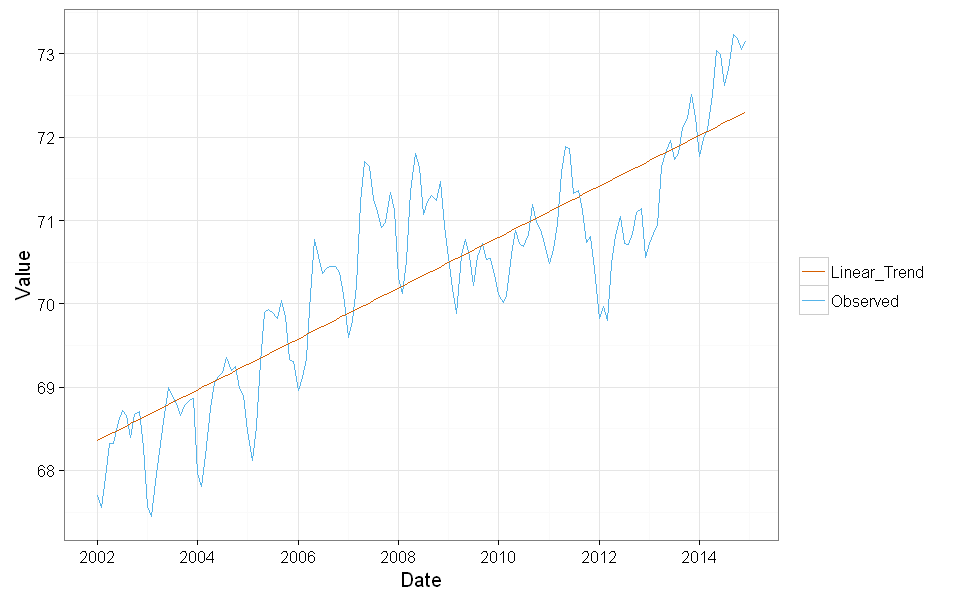

In [412]:
jp_linear_model <- lm(jp_data$Dt ~ index(jp_data))
summary(jp_linear_model)
jp_data$Linear_Fit <- jp_linear_model$fitted


ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Linear_Fit, color="Linear_Trend")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Linear_Trend="#D55E00")) +
    theme_bw()



Analyse trend, Polynomial model


Call:
lm(formula = jp_data$Dt ~ poly(index(jp_data), 3, raw = TRUE))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.91306 -0.34865 -0.02009  0.38773  0.95036 

Coefficients:
                                          Estimate    Std. Error t value
(Intercept)                          67.3396885424  0.1540726047 437.065
poly(index(jp_data), 3, raw = TRUE)1  0.0896149855  0.0084716621  10.578
poly(index(jp_data), 3, raw = TRUE)2 -0.0009191564  0.0001251702  -7.343
poly(index(jp_data), 3, raw = TRUE)3  0.0000036210  0.0000005242   6.908
                                                 Pr(>|t|)    
(Intercept)                          < 0.0000000000000002 ***
poly(index(jp_data), 3, raw = TRUE)1 < 0.0000000000000002 ***
poly(index(jp_data), 3, raw = TRUE)2      0.0000000000118 ***
poly(index(jp_data), 3, raw = TRUE)3      0.0000000001260 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4696 on 152 degrees of freedom
Multiple R

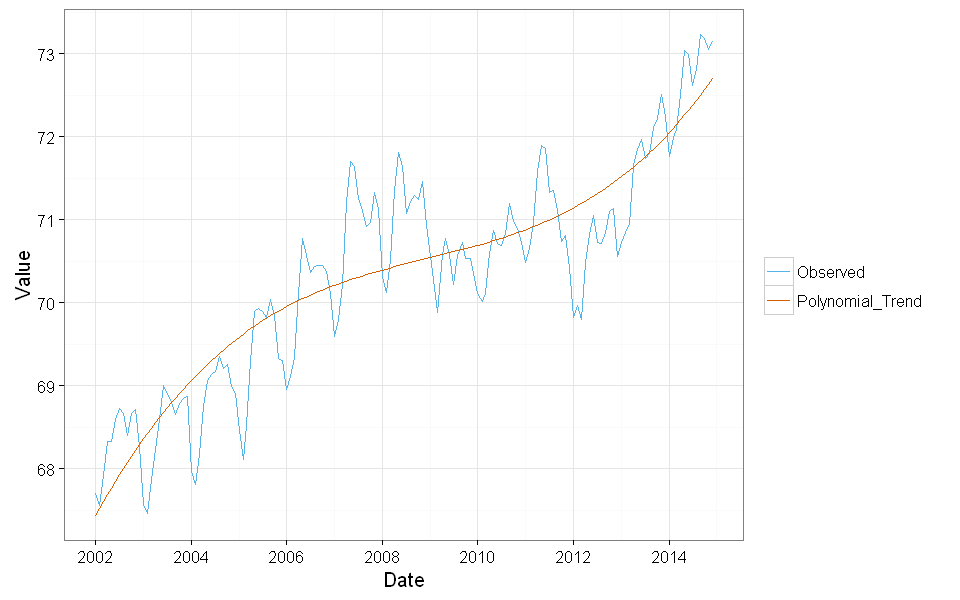

In [413]:
jp_pol_model <- lm(jp_data$Dt ~ poly(index(jp_data), 3, raw = TRUE))
summary(jp_pol_model)
jp_data$Pol_Fit <- jp_pol_model$fitted

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Pol_Fit, color="Polynomial_Trend")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Polynomial_Trend="#D55E00")) +
    theme_bw()


Analyse trend, exponetial smoothing model


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = jp_data$Dt, h = 24) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.0001 

  Initial states:
    l = 68.2887 
    b = 0.0309 

  sigma:  0.2044

     AIC     AICc      BIC 
300.4388 300.7037 312.6382 

Error measures:
                      ME      RMSE       MAE          MPE      MAPE      MASE
Training set 0.001201887 0.2044107 0.1672391 0.0009801408 0.2381937 0.9818585
                   ACF1
Training set 0.01233158

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
157       73.32473 73.06276 73.58669 72.92409 73.72536
158       73.35566 72.98518 73.72615 72.78905 73.92228
159       73.38660 72.93283 73.84038 72.69261 74.08060
160       73.41754 72.89354 73.94155 72.61615 74.21894
161       73.44848 72.86260 74.03437 72.55245 74.34452
162       73.47942 72.83759 74.12126 72.49782 74.46103
163       73.51036 72.81707 74.20366 72.45006 74.57067
164       73.54130 72.80010 74

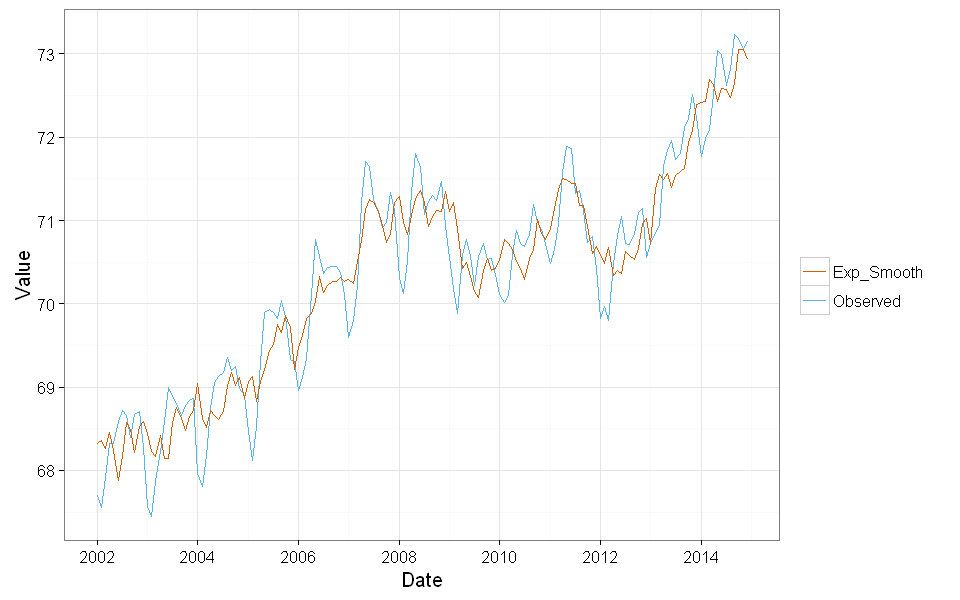

In [414]:
jp_holt_model <- holt(jp_data$Dt, h=24)
summary(jp_holt_model)
jp_data$Holt_Fit <- jp_holt_model$fit

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Holt_Fit, color="Exp_Smooth")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Exp_Smooth="#D55E00")) +
    theme_bw()

Residual Analysis, Pol

[1] 0.1942915

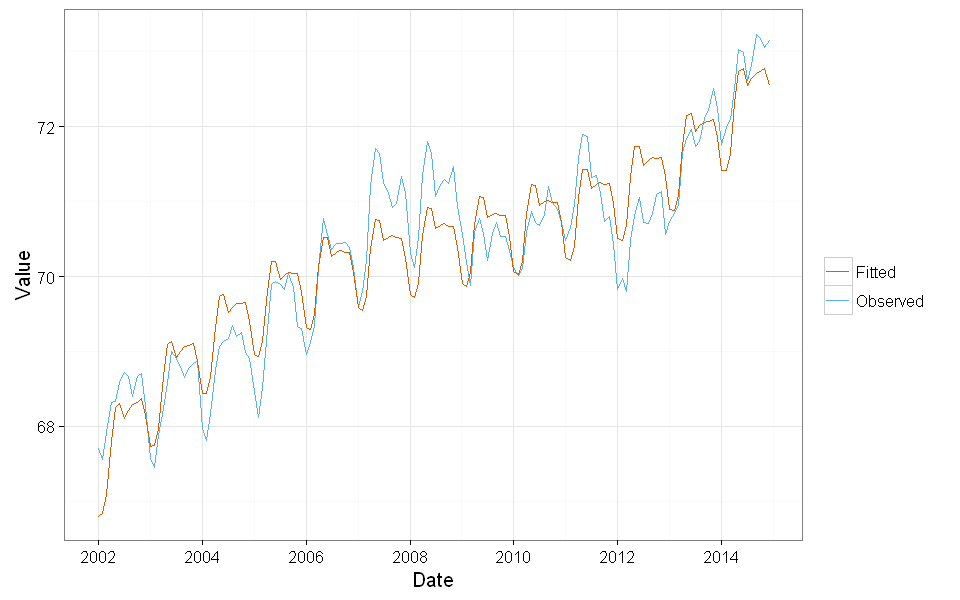

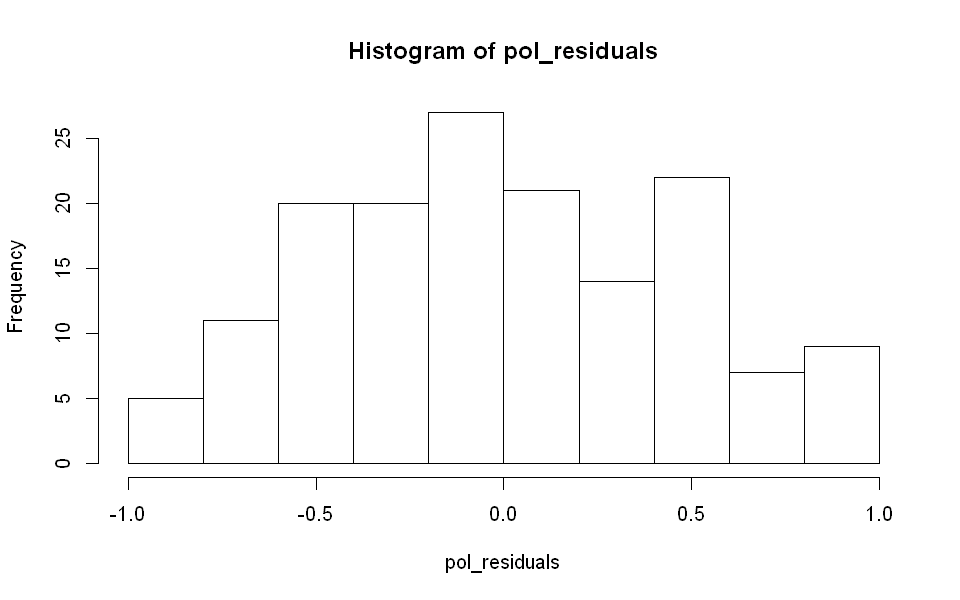

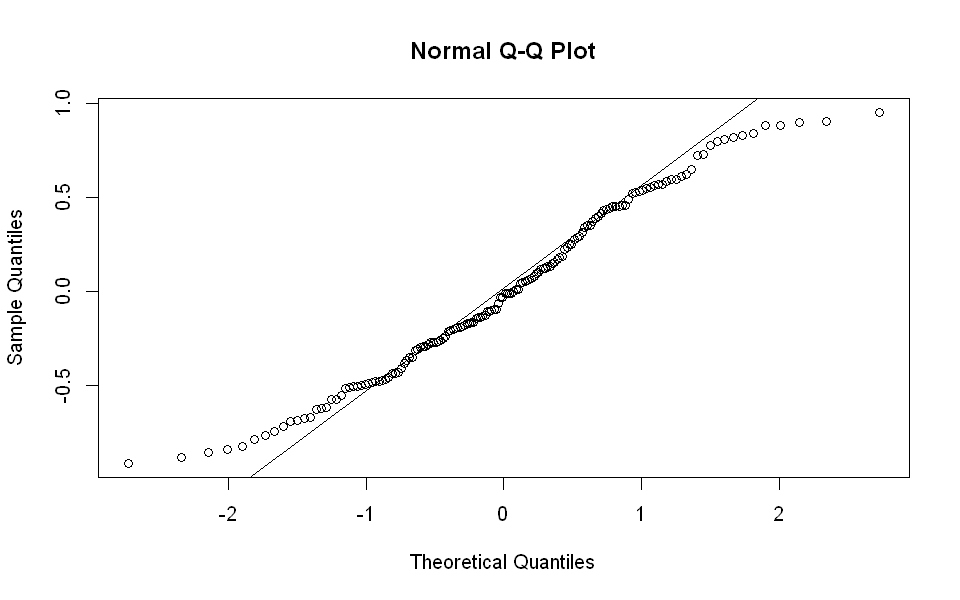

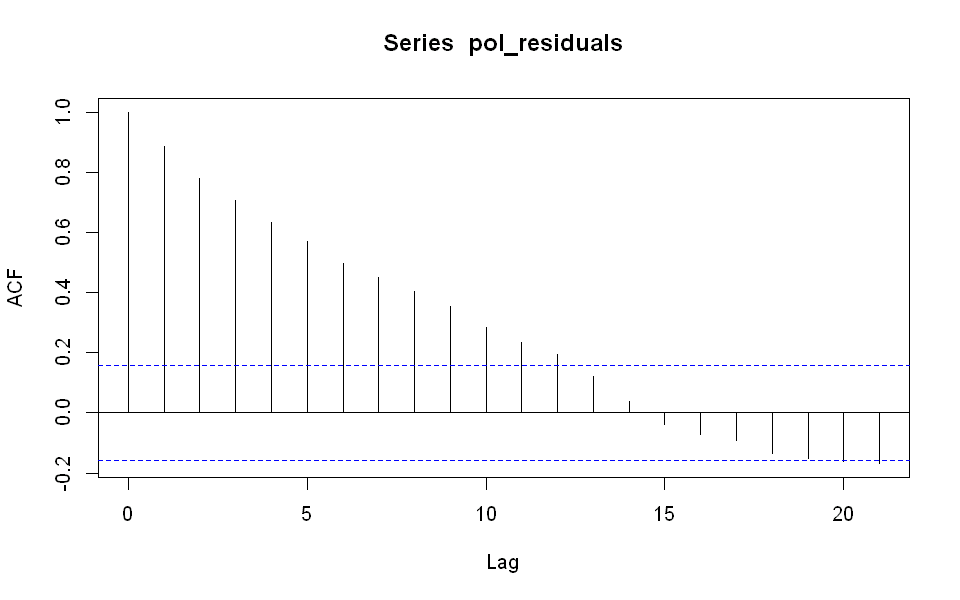

In [415]:
pol_residuals <- jp_data$Value - (jp_data$Pol_Fit + jp_data$Seasonal_Comp)
durbinWatsonTest(pol_residuals)

temp_data <- data.frame(Date = jp_data$Date, Value = jp_data$Value, Fitted = (jp_data$Pol_Fit + jp_data$Seasonal_Comp))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()

hist(pol_residuals)
qqnorm(pol_residuals)
qqline(pol_residuals)
acf(pol_residuals)

Residual Analysis, Holt

[1] 1.956133

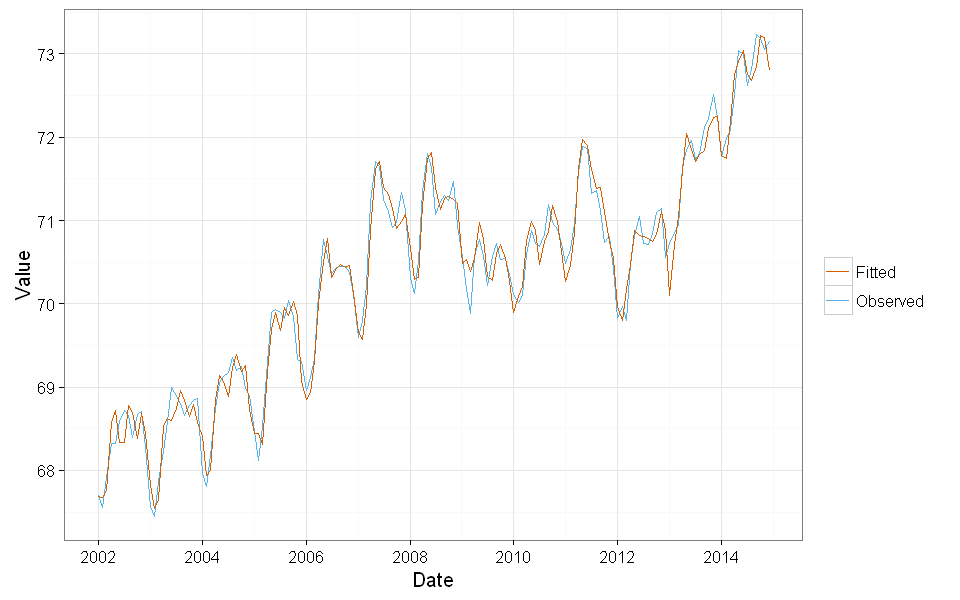

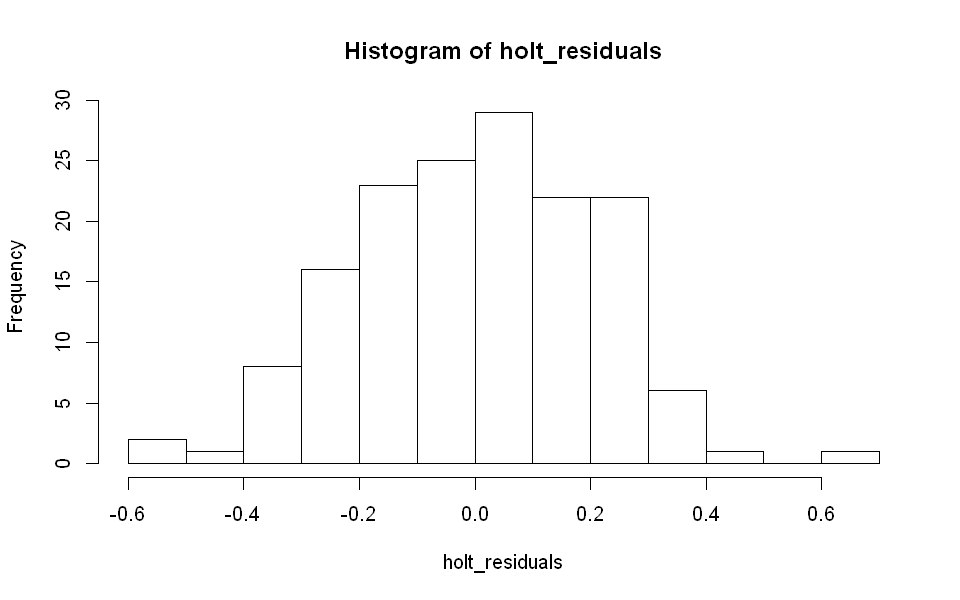

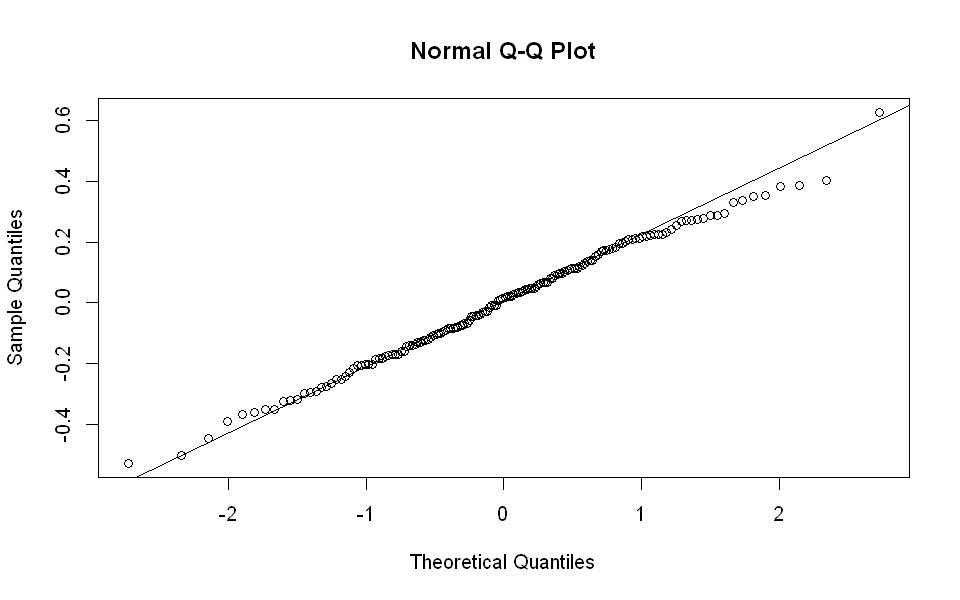

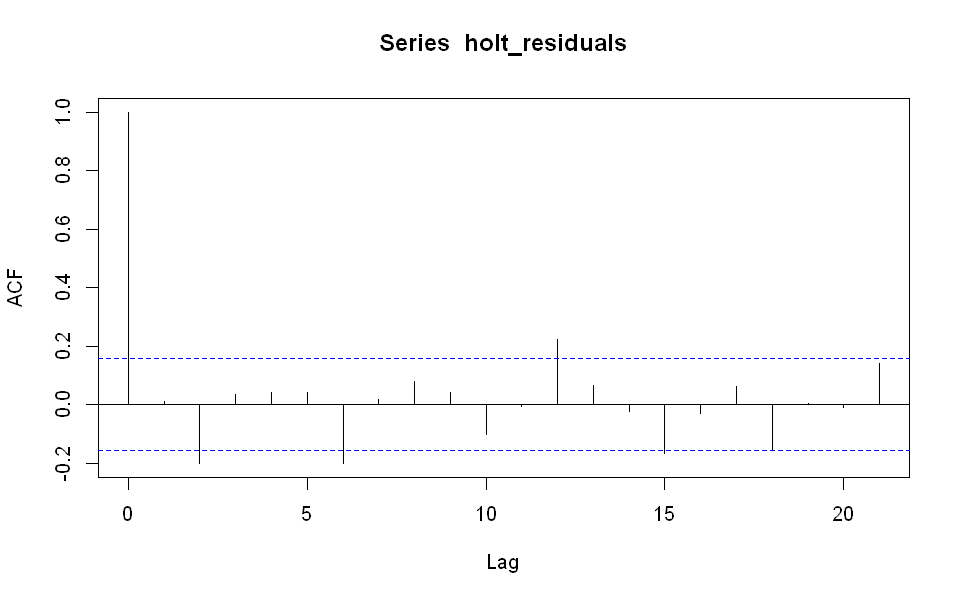

In [416]:
holt_residuals <- jp_data$Value - (jp_data$Holt_Fit + jp_data$Seasonal_Comp)
durbinWatsonTest(as.vector(holt_residuals))

temp_data <- data.frame(Date = jp_data$Date, Value = jp_data$Value, Fitted = (jp_data$Holt_Fit + jp_data$Seasonal_Comp))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()

hist(holt_residuals)
qqnorm(holt_residuals)
qqline(holt_residuals)
acf(holt_residuals)

Decompose time serie, cycle

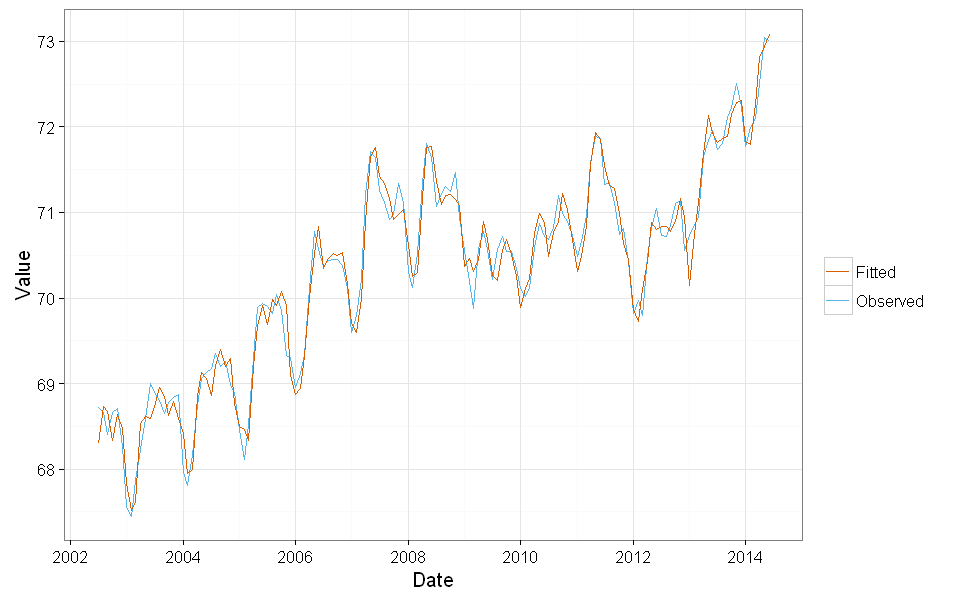

In [417]:
jp_data_shortend <- jp_data
jp_data_shortend$Clir <- jp_data_shortend$Value - (jp_data_shortend$Holt_Fit + jp_data_shortend$Seasonal_Comp)
jp_data_shortend$Cl <- ma(jp_data_shortend$Clir, 13)
jp_data_shortend <- na.omit(jp_data_shortend)
#jp_data_shortend$Ir <- jp_data_shortend$Clir - jp_data_shortend$Cl

#jp_data$Dt <- jp_data$Value - jp_data$Seasonal_Comp

#ggplot(jp_data, aes()) +
#    geom_line(aes(x = Date, y = Value, color="Observed")) +
#    geom_line(aes(x = Date, y = Dt, color="Dt")) +
#    scale_colour_manual(name="", values=c(Observed="#56B4E9", Dt="#D55E00")) +
#    theme_bw()



temp_data <- data.frame(Date = jp_data_shortend$Date,
                        Value = jp_data_shortend$Value,
                        Fitted = (jp_data_shortend$Holt_Fit + 
                                  jp_data_shortend$Seasonal_Comp + 
                                  jp_data_shortend$Cl))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()





Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = jp_data_shortend$Dt, h = 24) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.0001 

  Initial states:
    l = 68.4587 
    b = 0.0255 

  sigma:  0.1993

     AIC     AICc      BIC 
259.1395 259.4272 271.0187 

Error measures:
                      ME      RMSE       MAE         MPE     MAPE      MASE
Training set 0.002908578 0.1993098 0.1625734 0.003618664 0.231547 0.9832472
                   ACF1
Training set 0.01786887

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
145       72.56805 72.31262 72.82347 72.17741 72.95869
146       72.59354 72.23229 72.95478 72.04106 73.14602
147       72.61903 72.17658 73.06149 71.94236 73.29571
148       72.64453 72.13360 73.15545 71.86313 73.42592
149       72.67002 72.09876 73.24128 71.79635 73.54369
150       72.69551 72.06969 73.32133 71.73841 73.65262
151       72.72101 72.04501 73.39700 71.68716 73.75485
152       72.74650 72.023

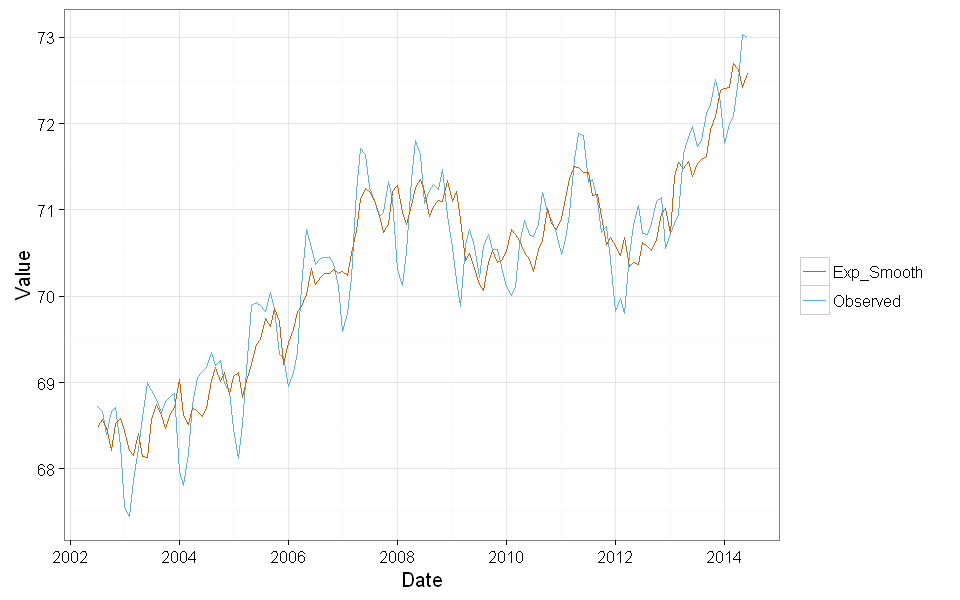

In [418]:
jp_holt_model_short <- holt(jp_data_shortend$Dt, h=24)
summary(jp_holt_model_short)
jp_data_shortend$Holt_Fit <- jp_holt_model_short$fit

ggplot(jp_data_shortend, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Holt_Fit, color="Exp_Smooth")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Exp_Smooth="#D55E00")) +
    theme_bw()

[1] 2.082665

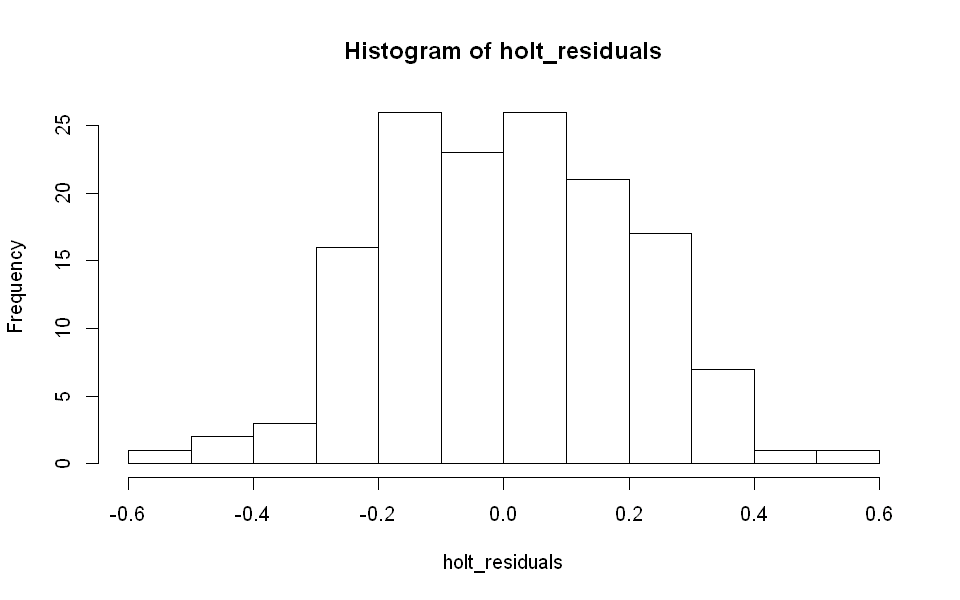

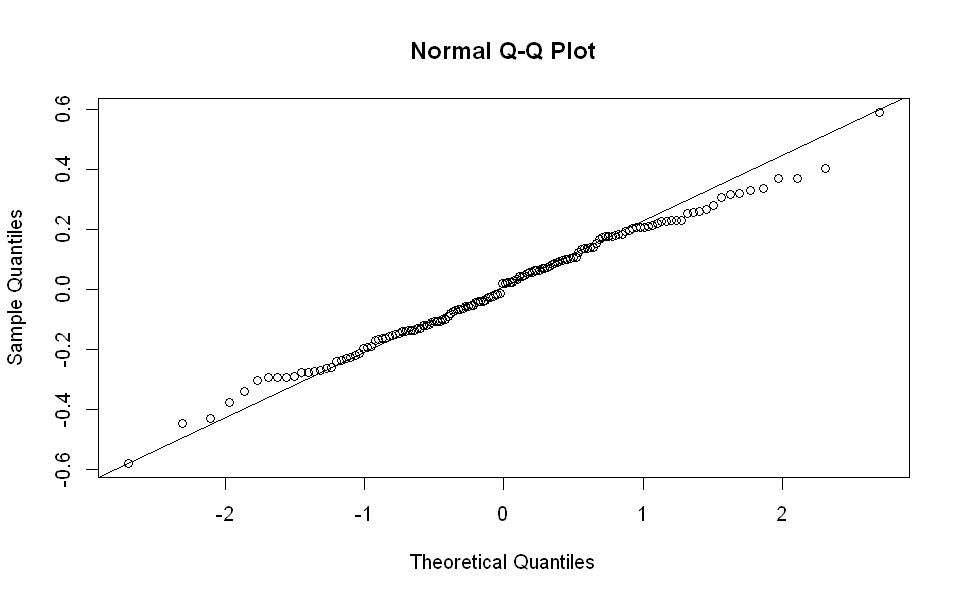

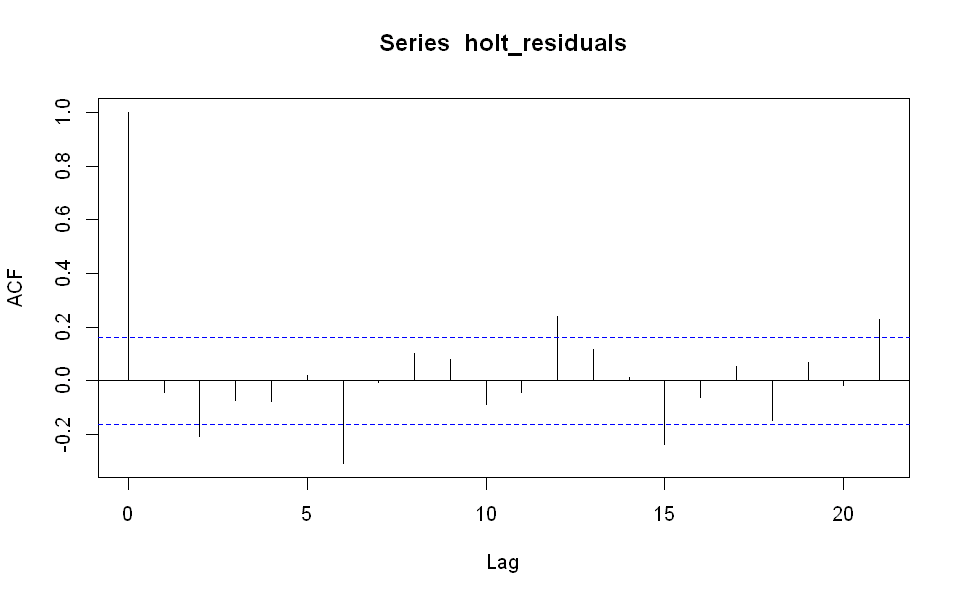

In [419]:
holt_residuals <- jp_data_shortend$Value - (jp_data_shortend$Holt_Fit + 
                                            jp_data_shortend$Seasonal_Comp + 
                                            jp_data_shortend$Cl)
durbinWatsonTest(as.vector(holt_residuals))

hist(holt_residuals)
qqnorm(holt_residuals)
qqline(holt_residuals)
acf(holt_residuals)

Predict

Warning message:
: Removed 24 rows containing missing values (geom_path).

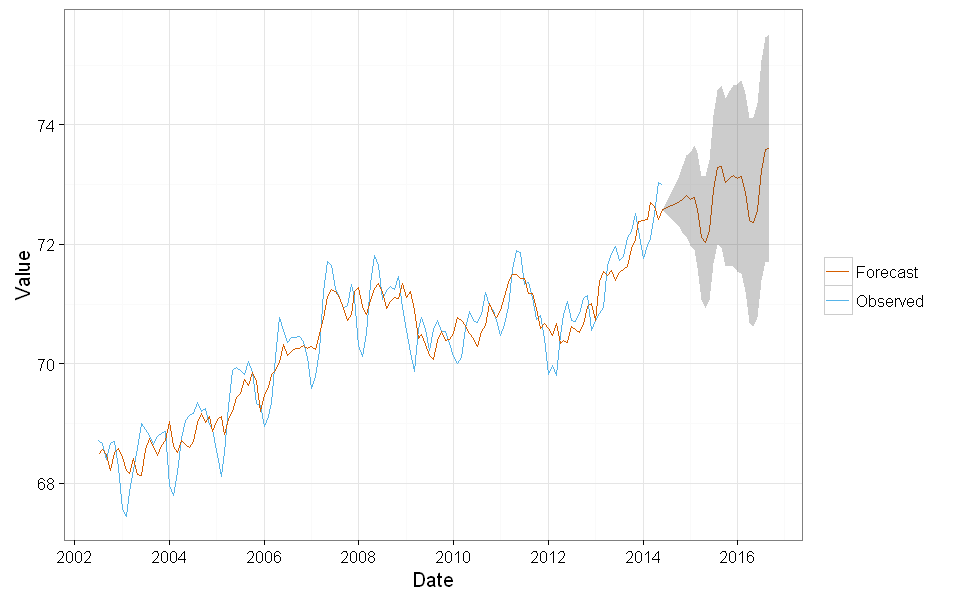

In [420]:
#help(holt)
#jp_holt_model <- holt(jp_data_shortend$Dt , h=24)
#summary(jp_holt_model)

forecast_mean <- jp_holt_model_short$mean + jp_data_shortend$Seasonal_Comp[1:24] + jp_data_shortend$Cl[1:24]
forecast_high <- jp_holt_model_short$lower[,2] + jp_data_shortend$Seasonal_Comp[1:24] + jp_data_shortend$Cl[1:24]
forecast_low <- jp_holt_model_short$upper[,2] + jp_data_shortend$Seasonal_Comp[1:24] + jp_data_shortend$Cl[1:24]

predict_data <- data.frame(Date = c(jp_data_shortend$Date, seq(as.Date("2014-10-01"), by = "month", length.out = 24)),
                        Value = c(jp_data_shortend$Value, rep(NA, 24)),
                        Forecast = c(jp_data_shortend$Holt_Fit, forecast_mean),
                        Forecast_low = c(jp_data_shortend$Holt_Fit, forecast_low),
                        Forecast_high = c(jp_data_shortend$Holt_Fit, forecast_high))
#predict_data

ggplot(predict_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
    geom_ribbon(aes(x = Date, ymin=Forecast_low, ymax=Forecast_high), alpha=.25) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#D55E00")) +
    theme_bw()


predict without cycle

Warning message:
: Removed 24 rows containing missing values (geom_path).

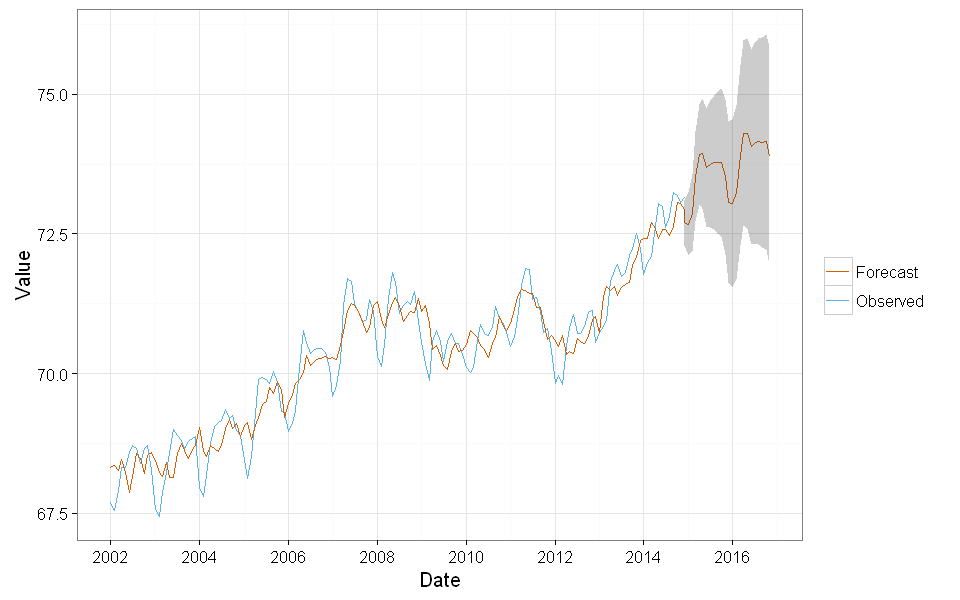

In [423]:
#help(holt)
#jp_holt_model <- holt(jp_data$Dt , h=24)
#summary(jp_holt_model)

forecast_mean <- jp_holt_model$mean + jp_data$Seasonal_Comp[1:24]
forecast_high <- jp_holt_model$lower[,2] + jp_data$Seasonal_Comp[1:24]
forecast_low <- jp_holt_model$upper[,2] + jp_data$Seasonal_Comp[1:24]

predict_data <- data.frame(Date = c(jp_data$Date, seq(as.Date("2014-12-01"), by = "month", length.out = 24)),
                        Value = c(jp_data$Value, rep(NA, 24)),
                        Forecast = c(jp_data$Holt_Fit, forecast_mean),
                        Forecast_low = c(jp_data$Holt_Fit, forecast_low),
                        Forecast_high = c(jp_data$Holt_Fit, forecast_high))
#predict_data

ggplot(predict_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
    geom_ribbon(aes(x = Date, ymin=Forecast_low, ymax=Forecast_high), alpha=.25) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#D55E00")) +
    theme_bw()